In [17]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# For Oxygen
#select_target = ['OXYGEN', 'OXYGEN_FLAG_W']
#fig_names = 'HOT_O_SVR_CV'
#model_names = 'O'
# For Slicate
#select_target = ['SILCAT', 'SILCAT_FLAG_W']
#fig_names = 'HOT_S_SVR_CV'
#model_names = 'S'
# For PHSPHT
select_target = ['PHSPHT', 'PHSPHT_FLAG_W']
fig_names = 'HOT_P_SVR_CV'
model_names = 'P'

# Read data from HOT
file_list = glob.glob('/home/jovyan/Ocean_ML/HOT/hot_rosette/*.csv')
fields = ['STNNBR', 'DATE', 'TIME', 'LATITUDE', 'LONGITUDE', 'CTDPRS', 'CTDTMP', 'CTDSAL', 'CTDOXY', 'CTDSAL_FLAG_W',
         'OXYGEN', 'OXYGEN_FLAG_W', 'SILCAT', 'SILCAT_FLAG_W', 'PHSPHT', 'PHSPHT_FLAG_W', 'NO2+NO3', 'NO2+NO3_FLAG_W']

df = pd.DataFrame(columns=fields)

for x in file_list:
    fil_name = x
    a = pd.read_csv(fil_name, skiprows=[0], comment='#')
    a = a[a.STNNBR==2]
    a = a[a.CTDSAL_FLAG_W==2 ]
    a = a[a[select_target[1]]==2]
    a = a[fields]
    #print(a.shape)
    df=df.append(a, ignore_index=True)
df.shape

(13540, 18)

In [18]:
# Quality control for nutrients vales (should not be < 0)
# nutrient_fields = ['CTDOXY', 'OXYGEN', 'SILCAT', 'PHSPHT', 'NO2+NO3']
nutrient_fields = ['CTDPRS', 'CTDTMP', 'CTDSAL', select_target[0]]
for x in nutrient_fields:
    print(x)
    print(df[x].astype(float).describe())

CTDPRS
count    13540.000000
mean      1203.222880
std       1391.431324
min          1.200000
25%        189.425000
50%        600.500000
75%       1800.100000
max       4813.800000
Name: CTDPRS, dtype: float64
CTDTMP
count    13540.000000
mean        10.073070
std          8.593655
min          1.440000
25%          2.392975
50%          5.868900
75%         19.226775
max         27.358000
Name: CTDTMP, dtype: float64
CTDSAL
count    13540.000000
mean        34.631143
std          0.370051
min         34.009100
25%         34.342925
50%         34.644050
75%         34.899925
max         35.546300
Name: CTDSAL, dtype: float64
PHSPHT
count    13540.000000
mean         1.728013
std          1.207106
min          0.000000
25%          0.220000
50%          2.470000
75%          2.810000
max          3.130000
Name: PHSPHT, dtype: float64


In [19]:
df[select_target[0]][df[select_target[0]].astype(float)<0] = 0

Follow the [sklearn instruction](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [20]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

input_var = ['CTDPRS', 'CTDTMP', 'CTDSAL']
output_var = [select_target[0]]
X_input = df[input_var]
y_output = df[output_var]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_input, y_output, test_size=0.3, random_state=2018)

# Stardarlized the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Run several models with default settings and see which one is the best.
'''
dict_model = {
    'Linear Regression': LinearRegression(),
    "Ridge Regression": Ridge(),
    "Linear SVR": SVR(),
}

dict_score={}
for model_name, model in dict_model.items():
    model.fit(X_train, y_train)
    # Test the model
    y_true, y_pred = y_test, model.predict(X_test)
    dict_score[model_name] = mean_squared_error(y_true, y_pred)
print(dict_score)
# plot observation vs prediction
dict_result = {'observation': y_true.values.astype(float).flatten(), 'prediction': np.array(y_pred)}
df_result = pd.DataFrame(dict_result)
sns.relplot(x="observation", y="prediction", data=df_result);
'''

'\ndict_model = {\n    \'Linear Regression\': LinearRegression(),\n    "Ridge Regression": Ridge(),\n    "Linear SVR": SVR(),\n}\n\ndict_score={}\nfor model_name, model in dict_model.items():\n    model.fit(X_train, y_train)\n    # Test the model\n    y_true, y_pred = y_test, model.predict(X_test)\n    dict_score[model_name] = mean_squared_error(y_true, y_pred)\nprint(dict_score)\n# plot observation vs prediction\ndict_result = {\'observation\': y_true.values.astype(float).flatten(), \'prediction\': np.array(y_pred)}\ndf_result = pd.DataFrame(dict_result)\nsns.relplot(x="observation", y="prediction", data=df_result);\n'

0.004061747103098032


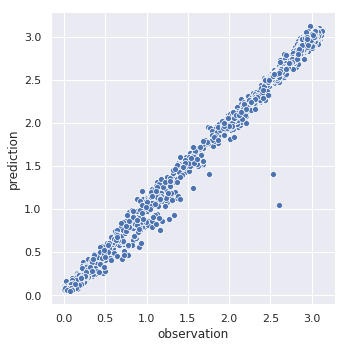

In [22]:
svr = SVR()
    
pipe = Pipeline(steps=[('svr', svr)])
Cs = np.arange(0.01, 3, 0.5)
kernels = [ 'poly', 'rbf', 'sigmoid']

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(svr__C=Cs, svr__kernel=kernels))
estimator.fit(X_train, y_train)
y_true, y_pred = y_test, estimator.predict(X_test)
print(mean_squared_error(y_true, y_pred))

# plot observation vs prediction
dict_result = {'observation': y_true.values.astype(float).flatten(), 'prediction': np.array(y_pred)}
df_result = pd.DataFrame(dict_result)
splot = sns.relplot(x="observation", y="prediction", data=df_result);
splot.savefig(fig_names+'.png')

In [23]:
from sklearn.externals import joblib


# Save the scaler function
joblib.dump(scaler, 'scaler_'+model_names+'.pkl')
# Save the best model
joblib.dump(estimator, 'model_'+model_names+'.pkl') 
# load model
#estimator = joblib.load('model_N.pkl') 
# load model
#estimator = joblib.load('model_N.pkl') 

['model_P.pkl']

In [24]:
model_names

'P'